## Assignment

In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **housing prices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings

sns.set_style('dark')

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hp_df = pd.read_sql_query('select * from houseprices',con=engine, index_col='id')

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
#exterqual and mszoning seem to have quite a bit of variance. let's use one-hot encoding for these two
hp_df = pd.concat([hp_df, pd.get_dummies(hp_df['mszoning'], prefix='mszoning', drop_first=True)], axis=1)
hp_df = pd.concat([hp_df, pd.get_dummies(hp_df['exterqual'], prefix='exterqual', drop_first=True)], axis=1)

dummy_col_names = list(pd.get_dummies(hp_df['mszoning'], prefix='mszoning', drop_first=True).columns)
dummy_col_names = dummy_col_names + list(pd.get_dummies(hp_df['exterqual'], prefix='exterqual', drop_first=True).columns)

In [4]:
# Linear Regression
y = hp_df['saleprice']
# X is the feature set which includes
X = hp_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_col_names]

In [5]:
# Splitting up train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
# Adding constant
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     443.6
Date:                Tue, 17 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:56:24   Log-Likelihood:                -13813.
No. Observations:                1168   AIC:                         2.765e+04
Df Residuals:                    1155   BIC:                         2.772e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.763e+04   1.52e+04     -1.814   

('Mean absolute error of the prediction is: 26069.74',
 'Mean squared error of the prediction is: 2450437531.35',
 'Root mean squared error of the prediction is: 49502.0',
 'Mean absolute percentage error of the prediction is: 15.19')

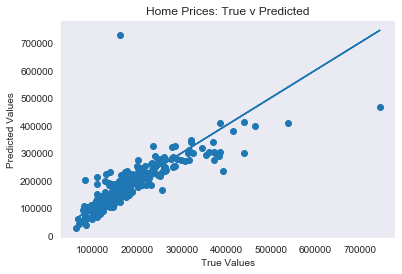

In [7]:
# Add constant to test
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Home Prices: True v Predicted')

def error_stats(y_test, ypreds):
    MAE = f"Mean absolute error of the prediction is: {round(mean_absolute_error(y_test, y_preds), 2)}"
    MSE = f"Mean squared error of the prediction is: {round(mse(y_test, y_preds),2)}"
    RMSE = f"Root mean squared error of the prediction is: {round(rmse(y_test, y_preds))}"
    MAPE = f"Mean absolute percentage error of the prediction is: {round(np.mean(np.abs((y_test - y_preds) / y_test) * 100),2)}"
    return MAE, MSE, RMSE, MAPE

error_stats(y_test, y_preds)

Looks like our model does well predicting prices up to \$250/275K, but is not the best at higher numbers. It is possible the best course of action would be to use a log transformation of the target. MAPE is an okay percentage, but I think we could adjust the features for it to perform better.

In [8]:
# get total home sq ft
hp_df['totalsqft'] = hp_df.totalbsmtsf + hp_df.firstflrsf + hp_df.secondflrsf

In [9]:
# run new model

# adjusting target to log(x+1)
y = np.log1p(hp_df.saleprice)

# choosing categories based on a Random Forest Regression I ran in another notebook
X = hp_df[['garagecars', 'overallqual', 'totalsqft']] 

# Splitting up train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# adding constant
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     1720.
Date:                Tue, 17 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:56:25   Log-Likelihood:                 403.28
No. Observations:                1168   AIC:                            -798.6
Df Residuals:                    1164   BIC:                            -778.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.5421      0.023    454.624      

('Mean absolute error of the prediction is: 0.13',
 'Mean squared error of the prediction is: 0.05',
 'Root mean squared error of the prediction is: 0.0',
 'Mean absolute percentage error of the prediction is: 1.12')

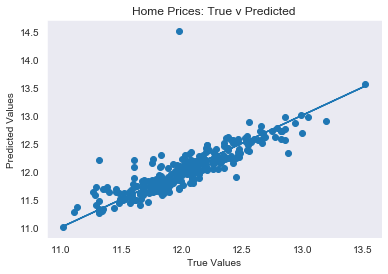

In [10]:
# Add constant to X Test too!
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Home Prices: True v Predicted')

error_stats(y_test, y_preds)

While R-squared and Adj. R-squared is ever so slightly lower, all other statistics are much better. AIC and BIC are much lower and not in scientific notation; all p-values significant; and, I believe most importantly, the MAPE is only 1.12%